In [329]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression

In [330]:
df_data = pd.read_excel(r"datos/Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


# 1.1 Calidad de datos

In [331]:
#Completitud

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [332]:
print("===Count==")
print(df_data.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df = df_data.dropna(subset=["textos", "labels"])
print(df.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()


===Count==
textos    2424
labels    2424
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    2424
labels    2424
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    2424
labels    2424
dtype: int64

In [333]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [334]:
# clases en el datset
df["labels"].unique()

array([4, 3, 1], dtype=int64)

In [335]:
df = df.drop(columns=["language"])

In [336]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

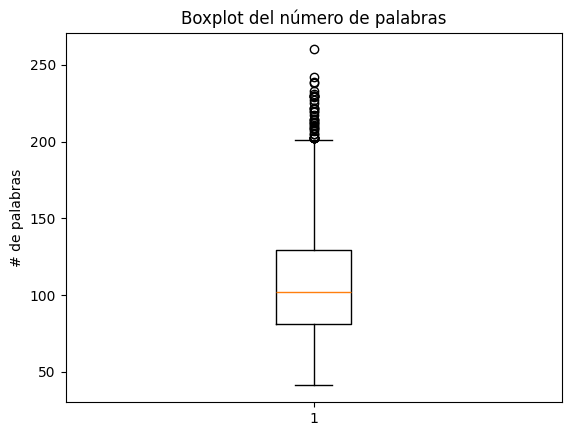

In [337]:
plt.boxplot(df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

In [338]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()


def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]", "", text, flags=re.U)  # Unicode aware
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [
        spanish_stemmer.stem(token) if stem else token
        for token in tokens
        if token not in stop_words
    ]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [339]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,93,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


In [340]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


In [341]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

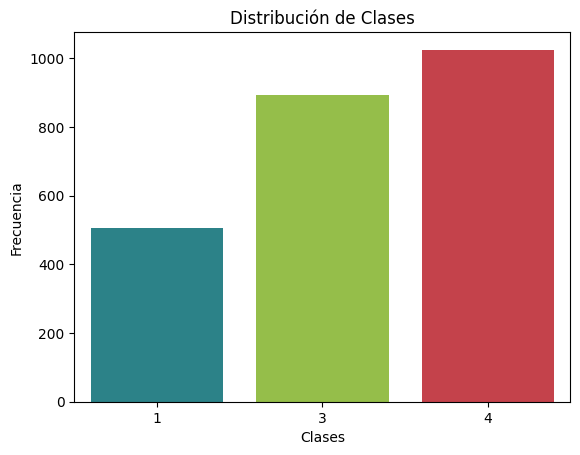

In [342]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [343]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [344]:
vectorizer_ngram = CountVectorizer(ngram_range=(1, 1))
X_train = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
X_test = vectorizer_ngram.transform(X_test_text.fillna(""))

best_model = LogisticRegression(max_iter=1000, random_state=42)

best_model.fit(X_train, y_train)

y_preds = best_model.predict(X_test)

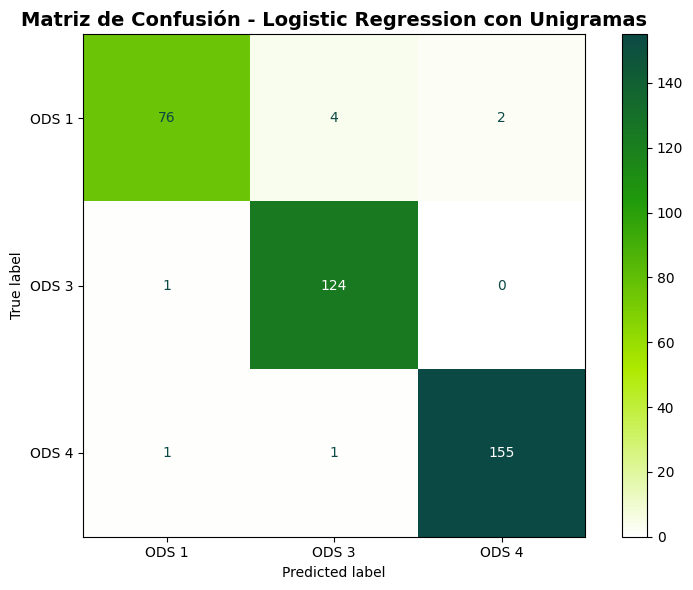

In [345]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

cm = confusion_matrix(y_test, y_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [346]:
from sklearn.model_selection import cross_val_score

# validación cruzada con 10 folds
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1_macro')
cv_scores_precision = cross_val_score(best_model, X_train, y_train, cv=10, scoring='precision_macro')
cv_scores_recall = cross_val_score(best_model, X_train, y_train, cv=10, scoring='recall_macro')

print("10-Fold Cross Validation Results:")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
print(f"Recall: {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")

10-Fold Cross Validation Results:
F1-Score: 0.9715 (+/- 0.0273)
Precision: 0.9748 (+/- 0.0248)
Recall: 0.9687 (+/- 0.0303)


# Validación nuevos Datos

In [347]:
df_data_2 = pd.read_excel(r"datos/Datos_etapa 2.xlsx")
df_data_2.head()

,textos,labels
0,La definición de privación está basada en el m...,1
1,La mayoría de los programas de protección soci...,1
2,Esto es dos veces y media mayor que la partici...,1
3,El enfoque aquí está en los aspectos de la pob...,1
4,El factor educativo representa una mayor contr...,1


In [348]:
#Completitud

df_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  99 non-null     object
 1   labels  99 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [349]:
print("===Count==")
print(df_data_2.count())
# Valores nulos por columna
print("==Datos Nulos==")
print(df_data_2.isnull().sum())

print("==Eliminar filas sin texto o etiqueta==")
df2 = df_data_2.dropna(subset=["textos", "labels"])
print(df2.count())

print("==verificar si hay textos con strings vacíos==")
num_empty = (df2["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

print("==Unicidad==")
duplicados = df2.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

print("== Eliminar duplicados exactos (mismo texto y misma etiqueta ==")
df2 = df2.drop_duplicates(subset=["textos", "labels"])
df2.count()


===Count==
textos    99
labels    99
dtype: int64
==Datos Nulos==
textos    0
labels    0
dtype: int64
==Eliminar filas sin texto o etiqueta==
textos    99
labels    99
dtype: int64
==verificar si hay textos con strings vacíos==
Número de textos vacíos: 0
==Unicidad==
Duplicados encontrados: 0
== Eliminar duplicados exactos (mismo texto y misma etiqueta ==


textos    99
labels    99
dtype: int64

In [350]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df2["language"] = df2["textos"].apply(detect_language)

print(len(df2[df2["language"] != "es"]))

0


In [351]:
# clases en el datset
df2["labels"].unique()

array([1, 3, 4], dtype=int64)

In [353]:
df2 = df2.drop(columns=["language"])

In [354]:
normalized_df2 = df2.copy()
normalized_df2[["tokenized_text", "tokens"]] = normalized_df2["textos"].apply(
    lambda x: pd.Series(tokenize_text(x, stem=False))
)

# recalcular word_count
normalized_df2["word_count"] = normalized_df2["textos"].apply(
    lambda x: len(str(x).split())
)

In [355]:
normalized_df2.head()

,textos,labels,tokenized_text,tokens,word_count
0,La definición de privación está basada en el m...,1,definición privación basada marco derechos niñ...,"[definición, privación, basada, marco, derecho...",100
1,La mayoría de los programas de protección soci...,1,mayoría programas protección social ghana aspi...,"[mayoría, programas, protección, social, ghana...",97
2,Esto es dos veces y media mayor que la partici...,1,dos veces media mayor participación correspond...,"[dos, veces, media, mayor, participación, corr...",61
3,El enfoque aquí está en los aspectos de la pob...,1,enfoque aquí aspectos pobreza reflejan situaci...,"[enfoque, aquí, aspectos, pobreza, reflejan, s...",80
4,El factor educativo representa una mayor contr...,1,factor educativo representa mayor contribución...,"[factor, educativo, representa, mayor, contrib...",58


In [356]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df2 = pd.DataFrame(
    {
        "cantidad": df2["labels"].value_counts(),
        "porcentaje": round(df2["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df2)

Distribución de clases:
        cantidad  porcentaje
labels                      
4             43        0.02
3             35        0.01
1             21        0.01


In [357]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

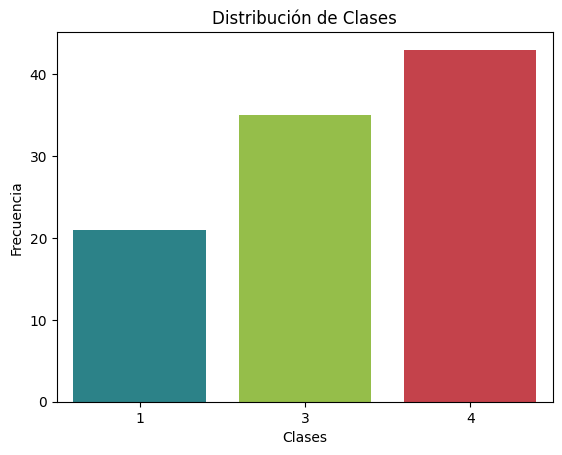

In [358]:
value_counts = df2["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [359]:
X_test

<364x12940 sparse matrix of type '<class 'numpy.int64'>'
	with 15792 stored elements in Compressed Sparse Row format>

In [360]:
X = normalized_df2["tokenized_text"]
y = normalized_df2["labels"]
X_test = X.copy()
y_test = y.copy()
# Ahora sí transformar el test (usar la variable correcta)
X_test = vectorizer_ngram.transform(X_test.fillna(""))

# Predecir con el modelo ya entrenado
y_preds = best_model.predict(X_test)

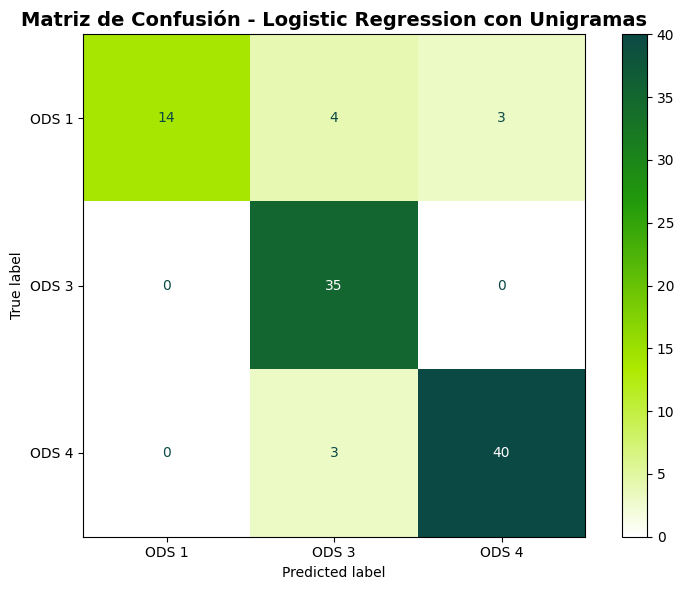

In [361]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
cm = confusion_matrix(y_test, y_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [362]:
print(f"Precision (macro): {precision_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"Recall    (macro): {recall_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"F1-score  (macro): {f1_score(y_test, y_preds, average='macro', zero_division=0):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")
print(f"Recall    (weighted): {recall_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")
print(f"F1-score  (weighted): {f1_score(y_test, y_preds, average='weighted', zero_division=0):.4f}")


Precision (macro): 0.9212
Recall    (macro): 0.8656
F1-score  (macro): 0.8798
Precision (weighted): 0.9108
Recall    (weighted): 0.8990
F1-score  (weighted): 0.8951


Es necesario unir ambos datos, los nuevos y los viejos y sobre estos generar el split. 

In [364]:
df = pd.concat([normalized_df,normalized_df2])
df.head()


,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaje educación consideran sinónimos esc...,"[aprendizaje, educación, consideran, sinónimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niños pequeños bebés niños pequeños capacitaci...,"[niños, pequeños, bebés, niños, pequeños, capa..."
2,"Además, la formación de especialistas en medic...",3,93,además formación especialistas medicina genera...,"[además, formación, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,países ocde tiende pasar cursos obligatorios o...,"[países, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,94,grupo centró personas padecen trastornos menta...,"[grupo, centró, personas, padecen, trastornos,..."


In [365]:
print(len(normalized_df), len(normalized_df2))
print(len(df))

2424 99
2523


In [367]:
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1068        0.42
3            929        0.37
1            526        0.21


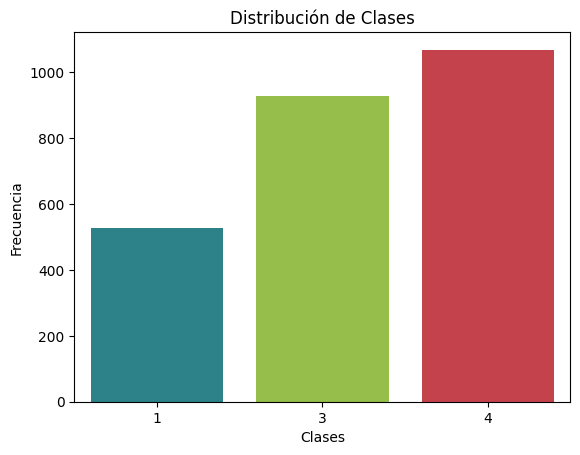

In [368]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [372]:
X = df["tokenized_text"]
y = df["labels"]
X_train_real, X_temp, y_train_real, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val_real, X_test_real, y_val_real, y_test_real = train_test_split(
    X_temp, y_temp,
    test_size=(1/3), 
    stratify=y_temp,
    random_state=42
)


# Crear DataFrames para cada conjunto
df_train_real = pd.DataFrame({"textos": X_train_real, "labels": y_train_real})
df_val_real = pd.DataFrame({"textos": X_val_real, "labels": y_val_real})
df_test_real = pd.DataFrame({"textos": X_test_real, "labels": y_test_real})

In [373]:
print("Tamaños -> train:", len(df_train_real), "val:", len(df_val_real), "test:", len(df_test_real))
print("Distribución original en train:\n", df_train_real[ODS].value_counts())

Tamaños -> train: 1766 val: 504 test: 253
Distribución original en train:
 labels
4    738
3    665
1    363
Name: count, dtype: int64


# Creación de datos sintéticos

In [244]:
from pathlib import Path
import sys, site, platform, os, subprocess

# cargar dotenv (instala python-dotenv si hace falta)
try:
    from dotenv import load_dotenv
    load_dotenv()   # carga .env desde el working dir o sus padres
except Exception:
    pass

secret = os.getenv("OPENAI_API_KEY")
if not secret:
    raise RuntimeError(
        "OPENAI_API_KEY no encontrada. Verifica .env en la ruta y que tenga formato: OPENAI_API_KEY=sk-... (sin comillas)"
    )

# No imprimir la clave. Verificar solo que se cargó:
print("OPENAI_API_KEY cargada correctamente:", bool(secret))

OPENAI_API_KEY cargada correctamente: True


In [245]:
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

Python exe: c:\Users\aleja\anaconda3\envs\bi\python.exe
Version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
Site-packages: ['c:\\Users\\aleja\\anaconda3\\envs\\bi', 'c:\\Users\\aleja\\anaconda3\\envs\\bi\\Lib\\site-packages']
OS: Windows-11-10.0.26100-SP0


In [247]:
from openai import OpenAI
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))

OK SDK v1.x, modelos: 96


In [ ]:
TEXTO = "textos"  # columna de la opinión
ODS = "labels"  # columna de etiqueta 1,3,4

In [374]:
# =====================================================
# 4️⃣ Balancear el conjunto de entrenamiento
# =====================================================
conteo = df_train_real[ODS].value_counts()
max_count = conteo.max()

# calcular cuántos ejemplos nuevos por clase
targets = {clase: max_count - count for clase, count in conteo.items() if count < max_count}
print("Ejemplos a generar por clase:", targets)

cols = [TEXTO, ODS]
df_before = df_train_real[cols].drop_duplicates().copy()
df = df_train_real.copy()  # trabajamos solo con train

# =====================================================
# 5️⃣ Funciones auxiliares IA-Gen
# =====================================================
def get_seeds_for_class(df, clase, n=8):
    """Selecciona hasta n ejemplos reales de esa clase como contexto"""
    s = (
        df[df[ODS] == clase][TEXTO]
        .dropna()
        .astype(str)
        .sample(min(n, sum(df[ODS] == clase)), random_state=42)
        .tolist()
    )
    return s

def request_examples(client, clase, seeds, n_to_generate, model="gpt-4o-mini", max_attempts=3):
    """Solicita ejemplos sintéticos al modelo"""
    prompt = f"""
Genera {n_to_generate} opiniones ciudadanas breves (1–2 oraciones) en español (Colombia),
realistas y respetuosas, sobre problemáticas locales que correspondan al ODS {clase}.
Requisitos:
- TODAS deben pertenecer exclusivamente al ODS {clase}.
- Varía zona (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política.
- Devuelve SOLO JSON: lista de objetos con llaves "textos" (string) y "labels" (entero {clase}).
Ejemplos de inspiración:
{chr(10).join(f"- {s}" for s in seeds) if seeds else "- (sin ejemplos de contexto)"}
    """
    for attempt in range(max_attempts):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Eres un generador de datos sintéticos."},
                    {"role": "user", "content": prompt},
                ],
                temperature=0.7,
            )
            raw = response.choices[0].message.content.strip()
            if raw.startswith("```"):
                raw = raw.strip("`")
                if "\n" in raw:
                    raw = raw.split("\n", 1)[1]
            data = json.loads(raw)
            valid = []
            for item in data:
                if isinstance(item, dict) and "textos" in item and "labels" in item:
                    valid.append({TEXTO: str(item["textos"]).strip(), ODS: int(item["labels"])})
            return pd.DataFrame(valid)
        except Exception as e:
            time.sleep(1 + attempt * 2)
    return pd.DataFrame(columns=cols)

# =====================================================
# 6️⃣ Generar datos sintéticos solo para el train
# =====================================================
batch_size = 20
added_summary = {}

for clase, needed in targets.items():
    added = 0
    seeds = get_seeds_for_class(df, clase, n=8)
    iterations = ceil(needed / batch_size)
    for i in range(iterations):
        remaining = needed - added
        if remaining <= 0:
            break
        to_request = min(batch_size, remaining)
        df_batch = request_examples(client, clase, seeds, to_request)
        if df_batch.empty:
            print(f"[WARN] No se obtuvo respuesta válida para clase {clase} en intento {i+1}.")
            continue
        df_batch[ODS] = clase
        df_batch = df_batch[cols].dropna().drop_duplicates()
        prev_len = len(df)
        df = pd.concat([df, df_batch], ignore_index=True)
        df = df.drop_duplicates(subset=cols).reset_index(drop=True)
        new_added_now = len(df) - prev_len
        added += new_added_now
        print(f"Clase {clase}: intento {i+1}/{iterations} -> agregados {new_added_now}, total {added}/{needed}")
        time.sleep(0.5)
        seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]
    added_summary[clase] = added

# =====================================================
# 7️⃣ Resultados finales
# =====================================================
added_rows = df.merge(df_before, on=cols, how="left", indicator=True).loc[lambda x: x["_merge"] == "left_only", cols]
print("Resumen agregado por clase:", added_summary)
print("Nuevas filas agregadas totales:", len(added_rows))

df_train_final = df  # train real + sintético

print("\nDistribución final en train (balanceada):")
print(df_train_final[ODS].value_counts())

Ejemplos a generar por clase: {3: 73, 1: 375}
Clase 3: intento 1/4 -> agregados 20, total 20/73


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 2/4 -> agregados 20, total 40/73


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 3/4 -> agregados 20, total 60/73


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 3: intento 4/4 -> agregados 13, total 73/73


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 1/19 -> agregados 20, total 20/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 2/19 -> agregados 20, total 40/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 3/19 -> agregados 20, total 60/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 4/19 -> agregados 20, total 80/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 5/19 -> agregados 20, total 100/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 6/19 -> agregados 21, total 121/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 7/19 -> agregados 20, total 141/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 8/19 -> agregados 20, total 161/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 9/19 -> agregados 20, total 181/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 10/19 -> agregados 20, total 201/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 11/19 -> agregados 20, total 221/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 12/19 -> agregados 19, total 240/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 13/19 -> agregados 20, total 260/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 14/19 -> agregados 20, total 280/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 15/19 -> agregados 20, total 300/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 16/19 -> agregados 20, total 320/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 17/19 -> agregados 20, total 340/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 18/19 -> agregados 20, total 360/375


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


Clase 1: intento 19/19 -> agregados 15, total 375/375
Resumen agregado por clase: {3: 73, 1: 375}
Nuevas filas agregadas totales: 448

Distribución final en train (balanceada):
labels
1    738
3    738
4    738
Name: count, dtype: int64


C:\Users\aleja\AppData\Local\Temp\ipykernel_3588\2899643463.py:95: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  seeds = list(pd.unique((seeds + df_batch[TEXTO].astype(str).tolist())))[-8:]


In [375]:
print(f"Tokens usados en el prompt: {response.usage.prompt_tokens}")
print(f"Tokens usados en la respuesta: {response.usage.completion_tokens}")
print(f"Tokens usados en total: {response.usage.total_tokens}")

Tokens usados en el prompt: 1197
Tokens usados en la respuesta: 743
Tokens usados en total: 1940


In [376]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df_train_final["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
1            738        0.33
3            738        0.33
4            738        0.33


In [377]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

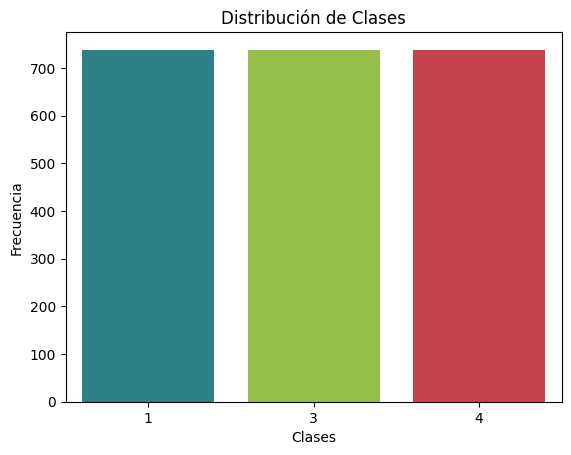

In [378]:
value_counts = df_train_final["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [379]:
# Entrenar solo con el train aumentado
X_train = df_train_final["textos"]
y_train = df_train_final["labels"]

# Validación y test siempre con datos reales
X_val = df_val_real["textos"]
y_val = df_val_real["labels"]
X_test = df_test_real["textos"]
y_test = df_test_real["labels"]

In [382]:
vectorizer_ngram = CountVectorizer(ngram_range=(1,1))
X_train_vec = vectorizer_ngram.fit_transform(X_train.fillna(""))
X_val_vec = vectorizer_ngram.transform(X_val.fillna(""))
X_test_vec = vectorizer_ngram.transform(X_test.fillna(""))

# Entrenamiento
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train_vec, y_train)

# Validación
y_val_preds = best_model.predict(X_val_vec)
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           1       0.97      0.93      0.95       108
           3       0.94      0.98      0.96       176
           4       0.99      0.98      0.98       220

    accuracy                           0.97       504
   macro avg       0.97      0.96      0.96       504
weighted avg       0.97      0.97      0.97       504



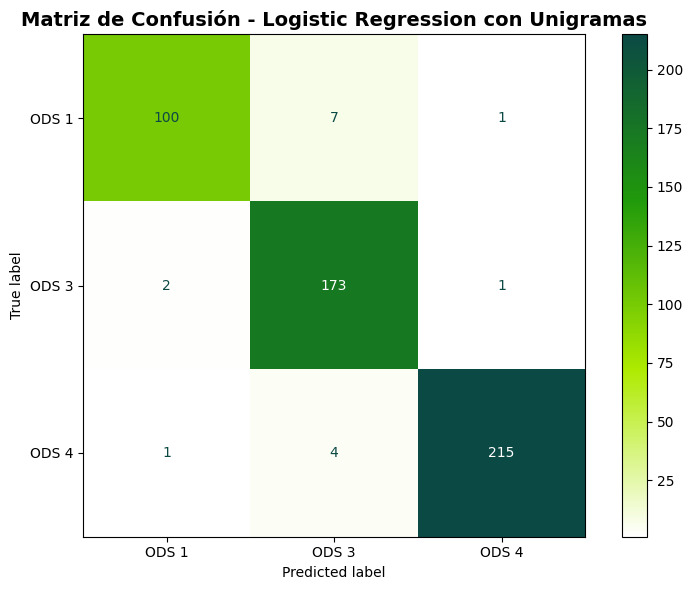

In [384]:

from matplotlib.colors import LinearSegmentedColormap

# Crear colormap personalizado con los colores especificados que se usan en la ppt
colors = ['#FFFFFF', '#AEEA00', '#219A0B', '#0B4944']
custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

cm = confusion_matrix(y_val, y_val_preds)

# Visualización 1: Usando ConfusionMatrixDisplay de sklearn
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["ODS 1", "ODS 3", "ODS 4"]
)
disp.plot(cmap=custom_cmap, values_format="d", ax=ax)
plt.title(
    "Matriz de Confusión - Logistic Regression con Unigramas",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [388]:
cv_scores_f1 = cross_val_score(best_model, X_train_vec, y_train, cv=10, scoring='f1_macro')
cv_scores_precision = cross_val_score(best_model, X_train_vec, y_train, cv=10, scoring='precision_macro')
cv_scores_recall = cross_val_score(best_model, X_train_vec, y_train, cv=10, scoring='recall_macro')

print("10-Fold Cross Validation Results:")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
print(f"Recall: {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")


10-Fold Cross Validation Results:
F1-Score: 0.9319 (+/- 0.2363)
Precision: 0.9496 (+/- 0.1355)
Recall: 0.9414 (+/- 0.1802)


In [385]:
df_train_final.to_excel(r"datos/Datos_aumentados_train.xlsx", index=False)